In [144]:
import pandas as pd
import sspa
import seaborn as sns
import matplotlib.pyplot as plt
import scipy


In [145]:
df = pd.read_csv('../Data/Su_COVID_metabolomics_processed_commoncases.csv', index_col=0)
reactome_pathways = sspa.process_gmt("../Data/Reactome_Homo_sapiens_pathways_compounds_R84.gmt")

In [157]:
df = pd.read_csv('../Data/Su_COVID_proteomics_processed_commoncases.csv', index_col=0)
reactome_pathways = sspa.process_reactome('Homo sapiens', infile = '../Data/UniProt2Reactome_all_Levels_ver84.txt', download_latest = False, filepath = None)

In [158]:
#Convert pathway ID to name
root_path = pd.read_excel('../Data/Root_pathways.xlsx', header=None)
root_pathway_dict = {root_path[0][i]:root_path[1][i] for i in range(0,len(root_path))}

root_pathway_names = list(root_pathway_dict.keys())
#Remove root pathways
reactome_pathways = reactome_pathways[~reactome_pathways.index.isin(root_pathway_names)]

In [159]:
for i in range(len(df.index)):
    if df.WHO_status[i] == '1-2':
        df['Group'][i] = 'Mild'
    else:
        df['Group'][i] = 'Severe'


C:\Users\jenna\AppData\Local\Temp\ipykernel_20852\897059123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group'][i] = 'Severe'
C:\Users\jenna\AppData\Local\Temp\ipykernel_20852\897059123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group'][i] = 'Mild'


### Over-representation analysis

309


,Entity,P-value,P-adjust
36,P26022,3.443423e-24,1.563314e-21
19,P07711,2.699109e-22,6.126978e-20
250,Q8NHJ6,5.495219e-21,8.316098e-19
198,P15514,1.475977e-20,1.675234e-18
270,Q9UQV4,7.344087e-20,6.668431e-18
...,...,...,...
203,P19474,9.568247e-01,9.645644e-01
385,P09769,9.581906e-01,9.645644e-01
442,Q9NXA8,9.616541e-01,9.659092e-01
241,Q15517,9.718159e-01,9.739612e-01


,ID,Pathway_name,Hits,Coverage,P-value,P-adjust
506,R-HSA-9694516,SARS-CoV-2 Infection,11/11,11/316,0.013701,0.995481
450,R-HSA-9006934,Signaling by Receptor Tyrosine Kinases,33/40,40/543,0.026543,0.995481
85,R-HSA-177929,Signaling by EGFR,9/9,9/52,0.030179,0.995481
31,R-HSA-1280218,Adaptive Immune System,38/48,48/879,0.053581,0.995481
88,R-HSA-180292,GAB1 signalosome,7/7,7/17,0.066188,0.995481
...,...,...,...,...,...,...
169,R-HSA-2262752,Cellular responses to stress,10/22,22/768,0.993457,0.996831
451,R-HSA-9006936,Signaling by TGFB family members,2/7,7/122,0.994923,0.996831
52,R-HSA-162906,HIV Infection,1/5,5/245,0.996831,0.996831
53,R-HSA-162909,Host Interactions of HIV factors,1/5,5/144,0.996831,0.996831


['11', '316']
['40', '543']
['9', '52']
['48', '879']
['7', '17']
['16', '509']
['16', '125']
['16', '118']
['6', '145']
['6', '114']
['  3.5%', '  7.4%', '  17.3%', '  5.5%', '  41.2%', '  3.1%', '  12.8%', '  13.6%', '  4.1%', '  5.3%']


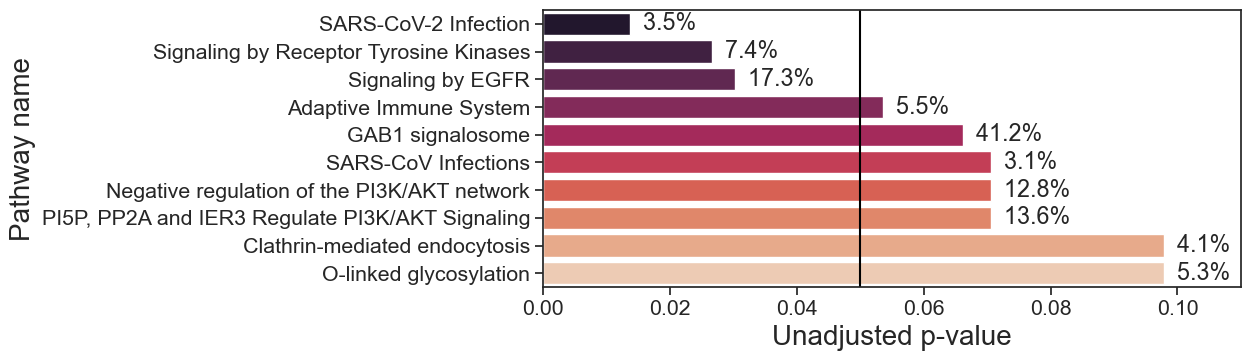

In [26]:
#Initiate an ORA object 
ora = sspa.sspa_ora(df.iloc[:,:-2], df["Group"], reactome_pathways, 0.05, custom_background=None)
#Carry out ORA
ora_res = ora.over_representation_analysis()
print(len(ora.DA_molecules))
display(ora.DA_test_res.sort_values(by="P-value"))
display(ora_res.sort_values(by="P-value"))


top_10_pathways = ora_res.sort_values(by="P-value").iloc[0:10, :]
plt.figure(figsize=(9, 3.6))

sns.set(font_scale = 1.4)
sns.set_style("ticks") # same as "white" but with ticks

#If you want to colour by significance
#bar_color = ['tab:green' if float(i) < 0.05 else 'tab:grey' for i in top_20_pathways['P-value']]
#sns.barplot(data=top_10_pathways, y="Pathway_name", x="P-value", orient="h", palette=bar_color) #rocket, magma

#If you want to colour by gradient
ax = sns.barplot(data=top_10_pathways, y="Pathway_name", x="P-value", orient="h", palette="rocket") #rocket, magma

label = []
for i in top_10_pathways.Coverage:
    num = i.split('/')
    print(num)
    percent = (int(num[0]) / int(num[1])) *100
    label.append("  "+ str(round(percent,1))+ '%')

print(label)

ax.bar_label(ax.containers[0], labels=label)

#plt.title('Metabolomics',fontsize=22,pad=10)
plt.xlabel('Unadjusted p-value',fontsize=20)
plt.ylabel('Pathway name',fontsize=20) 
plt.xlim(0, 0.11);

plt.axvline(0.05, c="black")



plt.savefig( '../Figures/proteomic_ORA_top_10.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [20]:
list(top_10_pathways.Coverage)

['4/71',
 '4/187',
 '16/301',
 '7/205',
 '3/12',
 '3/96',
 '3/39',
 '3/29',
 '3/141',
 '6/61']

For integrated data, take the two ORA results and combine the p-values with Fisher's method, which is what is commonly done (See Maghsoudi et al., 2021 for examples):

In [12]:
metabolomic_ora = ora_res.sort_values(by="P-value")

In [27]:
proteomic_ora = ora_res.sort_values(by="P-value")

In [29]:
metabolomic_ora.index = metabolomic_ora["ID"]
metabolomic_ora.drop(columns = ["ID"]) #using Sara's code to drop root pathways

,Pathway_name,Hits,Coverage,P-value,P-adjust
ID,,,,,
R-HSA-428157,Sphingolipid metabolism,4/4,4/71,0.113702,0.997896
R-HSA-597592,Post-translational protein modification,4/4,4/187,0.113702,0.997896
R-HSA-71291,Metabolism of amino acids and derivatives,12/16,16/301,0.127752,0.997896
R-HSA-196854,Metabolism of vitamins and cofactors,6/7,7/205,0.134338,0.997896
R-HSA-6814848,Glycerophospholipid catabolism,3/3,3/12,0.196449,0.997896
...,...,...,...,...,...
R-HSA-425397,"Transport of vitamins, nucleosides, and relate...",6/16,16/66,0.975858,0.997896
R-HSA-5619115,Disorders of transmembrane transporters,6/17,17/102,0.986544,0.997896
R-HSA-211859,Biological oxidations,5/16,16/335,0.993782,0.997896


In [28]:
proteomic_ora.index = proteomic_ora["ID"]
proteomic_ora.drop(columns = ["ID"]) #using Sara's code to drop root pathways

,Pathway_name,Hits,Coverage,P-value,P-adjust
ID,,,,,
R-HSA-9694516,SARS-CoV-2 Infection,11/11,11/316,0.013701,0.995481
R-HSA-9006934,Signaling by Receptor Tyrosine Kinases,33/40,40/543,0.026543,0.995481
R-HSA-177929,Signaling by EGFR,9/9,9/52,0.030179,0.995481
R-HSA-1280218,Adaptive Immune System,38/48,48/879,0.053581,0.995481
R-HSA-180292,GAB1 signalosome,7/7,7/17,0.066188,0.995481
...,...,...,...,...,...
R-HSA-2262752,Cellular responses to stress,10/22,22/768,0.993457,0.996831
R-HSA-9006936,Signaling by TGFB family members,2/7,7/122,0.994923,0.996831
R-HSA-162906,HIV Infection,1/5,5/245,0.996831,0.996831


In [30]:
result = metabolomic_ora.merge(proteomic_ora, how='inner',right_index=True, left_index = True)
result[:5]

,ID_x,Pathway_name_x,Hits_x,Coverage_x,P-value_x,P-adjust_x,ID_y,Pathway_name_y,Hits_y,Coverage_y,P-value_y,P-adjust_y
ID,,,,,,,,,,,,
R-HSA-428157,R-HSA-428157,Sphingolipid metabolism,4/4,4/71,0.113702,0.997896,R-HSA-428157,Sphingolipid metabolism,1/3,3/91,0.967880,0.995481
R-HSA-597592,R-HSA-597592,Post-translational protein modification,4/4,4/187,0.113702,0.997896,R-HSA-597592,Post-translational protein modification,27/38,38/1429,0.415531,0.995481
R-HSA-71291,R-HSA-71291,Metabolism of amino acids and derivatives,12/16,16/301,0.127752,0.997896,R-HSA-71291,Metabolism of amino acids and derivatives,5/9,9/376,0.877946,0.995481
R-HSA-196854,R-HSA-196854,Metabolism of vitamins and cofactors,6/7,7/205,0.134338,0.997896,R-HSA-196854,Metabolism of vitamins and cofactors,5/7,7/192,0.602981,0.995481
R-HSA-2262752,R-HSA-2262752,Cellular responses to stress,3/3,3/96,0.196449,0.997896,R-HSA-2262752,Cellular responses to stress,10/22,22/768,0.993457,0.996831


In [31]:
result["combined_pval"] = 0

In [32]:
for i in range(len(result.index)):
    ID_list = [result["P-value_x"][i],result["P-value_y"][i]]
    print(ID_list)
    test_stat,pval = scipy.stats.combine_pvalues(ID_list, method='fisher',weights=None)
    print(pval)
    result["combined_pval"][i] = pval


[0.1137023351415664, 0.9678801105310432]
0.3529110975440537
[0.1137023351415664, 0.4155308576440762]
0.1914616195792399
[0.12775205604398326, 0.877946285088071]
0.3575456658681867
[0.1343381968096432, 0.602980921134584]
0.2845862649756502
[0.19644906071579532, 0.9934574619687095]
0.5140450456158481
[0.19644906071579532, 0.7596623655120013]
0.43311466729161074
[0.30585582553278495, 0.4627592846515155]
0.4182705271707572
[0.3386699952965013, 0.8984741955246959]
0.6663218964970365
[0.3386699952965013, 0.8114854487167407]
0.6297956704874301
[0.3386699952965013, 0.9621094507142552]
0.691217610372946
[0.3386699952965013, 0.7596623655120013]
0.6065538386065297
[0.3386699952965013, 0.4627592846515155]
0.4471732904989808
[0.3386699952965013, 0.9850621546720174]
0.6998423567810675
[0.3386699952965013, 0.7596623655120013]
0.6065538386065297
[0.3386699952965013, 0.4627592846515155]
0.4471732904989808
[0.5022997073002744, 0.944690353450793]
0.8282499280951756
[0.5079684907308655, 0.1526681101543027

C:\Users\jenna\AppData\Local\Temp\ipykernel_20852\54959011.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["combined_pval"][i] = pval


In [33]:
result[:10]

,ID_x,Pathway_name_x,Hits_x,Coverage_x,P-value_x,P-adjust_x,ID_y,Pathway_name_y,Hits_y,Coverage_y,P-value_y,P-adjust_y,combined_pval
ID,,,,,,,,,,,,,
R-HSA-428157,R-HSA-428157,Sphingolipid metabolism,4/4,4/71,0.113702,0.997896,R-HSA-428157,Sphingolipid metabolism,1/3,3/91,0.967880,0.995481,0.352911
R-HSA-597592,R-HSA-597592,Post-translational protein modification,4/4,4/187,0.113702,0.997896,R-HSA-597592,Post-translational protein modification,27/38,38/1429,0.415531,0.995481,0.191462
R-HSA-71291,R-HSA-71291,Metabolism of amino acids and derivatives,12/16,16/301,0.127752,0.997896,R-HSA-71291,Metabolism of amino acids and derivatives,5/9,9/376,0.877946,0.995481,0.357546
R-HSA-196854,R-HSA-196854,Metabolism of vitamins and cofactors,6/7,7/205,0.134338,0.997896,R-HSA-196854,Metabolism of vitamins and cofactors,5/7,7/192,0.602981,0.995481,0.284586
R-HSA-2262752,R-HSA-2262752,Cellular responses to stress,3/3,3/96,0.196449,0.997896,R-HSA-2262752,Cellular responses to stress,10/22,22/768,0.993457,0.996831,0.514045
R-HSA-196849,R-HSA-196849,Metabolism of water-soluble vitamins and cofac...,3/3,3/141,0.196449,0.997896,R-HSA-196849,Metabolism of water-soluble vitamins and cofac...,2/3,3/127,0.759662,0.995481,0.433115
R-HSA-1483257,R-HSA-1483257,Phospholipid metabolism,4/5,5/113,0.305856,0.997896,R-HSA-1483257,Phospholipid metabolism,2/2,2/211,0.462759,0.995481,0.418271
R-HSA-2151201,R-HSA-2151201,Transcriptional activation of mitochondrial bi...,2/2,2/16,0.338670,0.997896,R-HSA-2151201,Transcriptional activation of mitochondrial bi...,1/2,2/57,0.898474,0.995481,0.666322
R-HSA-2187338,R-HSA-2187338,Visual phototransduction,2/2,2/71,0.338670,0.997896,R-HSA-2187338,Visual phototransduction,3/5,5/100,0.811485,0.995481,0.629796


In [40]:
result.Coverage_x[0]

'4/71'

2.13903743315508
2.6592022393282013
2.3991198362416406
5.405405405405405
5.3627760252365935
5.384090715320999
3.414634146341464
3.6458333333333335
3.5302337398373984
5.633802816901409
3.296703296703297
4.465253056802353
5.3156146179401995
2.393617021276596
3.854615819608398
7.5
4.38871473354232
5.944357366771159
7.575757575757576
2.272727272727273
4.924242424242425
4.424778761061947
0.9478672985781991
2.686323029820073
2.127659574468085
2.3622047244094486
2.2449321494387666
10.526315789473683
4.25531914893617
7.390817469204927
['  2.4%', '  5.4%', '  3.5%', '  4.5%', '  3.9%', '  5.9%', '  4.9%', '  2.7%', '  2.2%', '  7.4%']


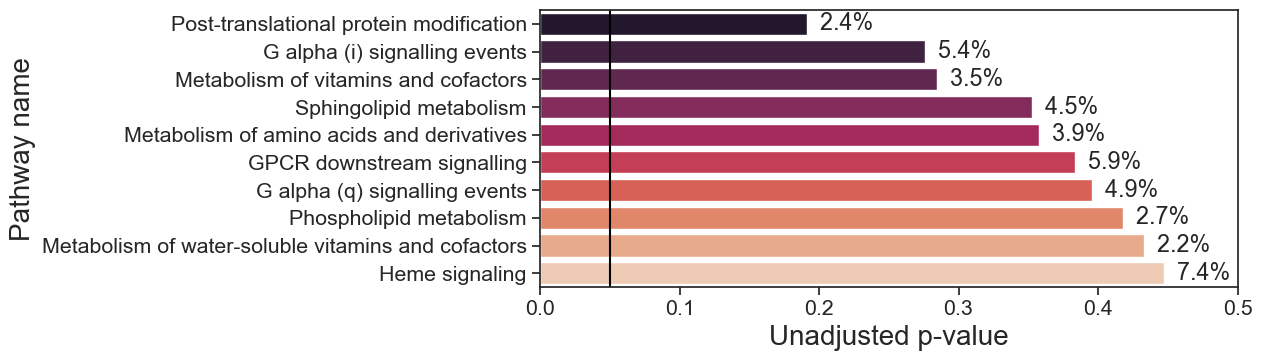

In [61]:
top_10_pathways = result.sort_values(by="combined_pval").iloc[0:10, :]
plt.figure(figsize=(9, 3.6))
sns.set(font_scale = 1.4)
sns.set_style("ticks") # same as "white" but with ticks

ax = sns.barplot(data=top_10_pathways, y="Pathway_name_x", x="combined_pval", orient="h", palette="rocket") #rocket, magma

label = []
percent1 = []
percent2

for i in range(10):
    pathway1 =  top_10_pathways.Coverage_x[i]
    num = pathway1.split('/')
    percent1 = (int(num[0]) / int(num[1])) *100
    print(percent1)

    pathway2 =  top_10_pathways.Coverage_y[i]
    num = pathway2.split('/')
    percent2 = (int(num[0]) / int(num[1])) *100
    print(percent2)

    percent = (percent1+percent2)/2
    print(percent)
    label.append("  "+ str(round(percent,1))+ '%')

print(label)
ax.bar_label(ax.containers[0], labels=label)

#plt.title('ORA for integrated data',fontsize=22,pad=10)
plt.xlabel('Unadjusted p-value',fontsize=20)
plt.ylabel('Pathway name',fontsize=20) 
plt.xlim(0, 0.5);

plt.axvline(0.05, c="black")

plt.savefig( '../Figures/integrated_ORA_top_10.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

### Gene-set Enrichment Analysis

In [160]:
gsea_res = sspa.sspa_gsea(df.iloc[:,:-2], df["Group"], reactome_pathways)

In [161]:
#display(gsea_res.sort_values(by="P-adjust FDR")) #0.55 is the lowest for metabolomic, 0.06 for proteomic
display(gsea_res.sort_values(by="P-value"))

,Pathway_ID,Pathway_name,ES,NES,P-value,P-adjust FDR,P-adjust FWER,Tag %,Entity %,Leading_edge
0,R-HSA-381426,Regulation of Insulin-like Growth Factor (IGF)...,0.894649,1.840192,0.0,0.094269,0.08,5/8,7.27%,P05231;Q07065;P19022;P13611;P09603
3,R-HSA-8957275,Post-translational protein phosphorylation,0.92116,1.668227,0.0,0.320732,0.426,5/6,7.27%,P05231;Q07065;P19022;P13611;P09603
10,R-HSA-201451,Signaling by BMP,-0.964602,-1.490586,0.001984,1.0,0.911,2/2,4.19%,Q15797;Q9UK05
1,R-HSA-6785807,Interleukin-4 and Interleukin-13 signaling,0.681918,1.82879,0.002053,0.056074,0.095,12/22,17.40%,P05231;P01375;P14210;P10145;P13500;P24394;P137...
2,R-HSA-9006936,Signaling by TGFB family members,-0.723535,-1.686862,0.005848,1.0,0.402,2/7,4.19%,Q15797;Q9UK05
...,...,...,...,...,...,...,...,...,...,...
573,R-HSA-8940973,RUNX2 regulates osteoblast differentiation,-0.307673,-0.488683,0.989754,0.998936,1.0,1/2,27.31%,P07947
577,R-HSA-71291,Metabolism of amino acids and derivatives,0.179672,0.417433,0.994275,0.998964,1.0,5/9,43.61%,P23526;P50135;Q9UJM8;P05089;P25786
575,R-HSA-9034015,Signaling by NTRK3 (TRKC),-0.310756,-0.465698,0.997899,0.997423,1.0,1/2,27.09%,P20783
574,R-HSA-9603381,Activated NTRK3 signals through PI3K,-0.310756,-0.465698,0.997899,0.997423,1.0,1/2,27.09%,P20783


In [162]:
#Change name to have a line break otherwise it won't fit on the plot
gsea_res.Pathway_name[0] = 'Regulation of Insulin-like Growth Factor (IGF) transport and \n uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs)'

In [151]:
top_10_pathways

,ID_x,Pathway_name_x,Hits_x,Coverage_x,P-value_x,P-adjust_x,ID_y,Pathway_name_y,Hits_y,Coverage_y,P-value_y,P-adjust_y,combined_pval
ID,,,,,,,,,,,,,
R-HSA-597592,R-HSA-597592,Post-translational protein modification,4/4,4/187,0.113702,0.997896,R-HSA-597592,Post-translational protein modification,27/38,38/1429,0.415531,0.995481,0.191462
R-HSA-418594,R-HSA-418594,G alpha (i) signalling events,4/6,6/111,0.507968,0.997896,R-HSA-418594,G alpha (i) signalling events,14/17,17/317,0.152668,0.995481,0.275834
R-HSA-196854,R-HSA-196854,Metabolism of vitamins and cofactors,6/7,7/205,0.134338,0.997896,R-HSA-196854,Metabolism of vitamins and cofactors,5/7,7/192,0.602981,0.995481,0.284586
R-HSA-428157,R-HSA-428157,Sphingolipid metabolism,4/4,4/71,0.113702,0.997896,R-HSA-428157,Sphingolipid metabolism,1/3,3/91,0.967880,0.995481,0.352911
R-HSA-71291,R-HSA-71291,Metabolism of amino acids and derivatives,12/16,16/301,0.127752,0.997896,R-HSA-71291,Metabolism of amino acids and derivatives,5/9,9/376,0.877946,0.995481,0.357546
R-HSA-388396,R-HSA-388396,GPCR downstream signalling,6/12,12/160,0.813513,0.997896,R-HSA-388396,GPCR downstream signalling,22/28,28/638,0.153000,0.995481,0.383822
R-HSA-416476,R-HSA-416476,G alpha (q) signalling events,2/5,5/66,0.900598,0.997896,R-HSA-416476,G alpha (q) signalling events,5/5,5/220,0.144540,0.995481,0.395580
R-HSA-1483257,R-HSA-1483257,Phospholipid metabolism,4/5,5/113,0.305856,0.997896,R-HSA-1483257,Phospholipid metabolism,2/2,2/211,0.462759,0.995481,0.418271
R-HSA-196849,R-HSA-196849,Metabolism of water-soluble vitamins and cofac...,3/3,3/141,0.196449,0.997896,R-HSA-196849,Metabolism of water-soluble vitamins and cofac...,2/3,3/127,0.759662,0.995481,0.433115


['  7.27%', '  7.27%', '  4.19%', '  17.40%', '  4.19%', '  4.63%', '  8.37%', '  5.73%', '  5.73%', '  1.76%']


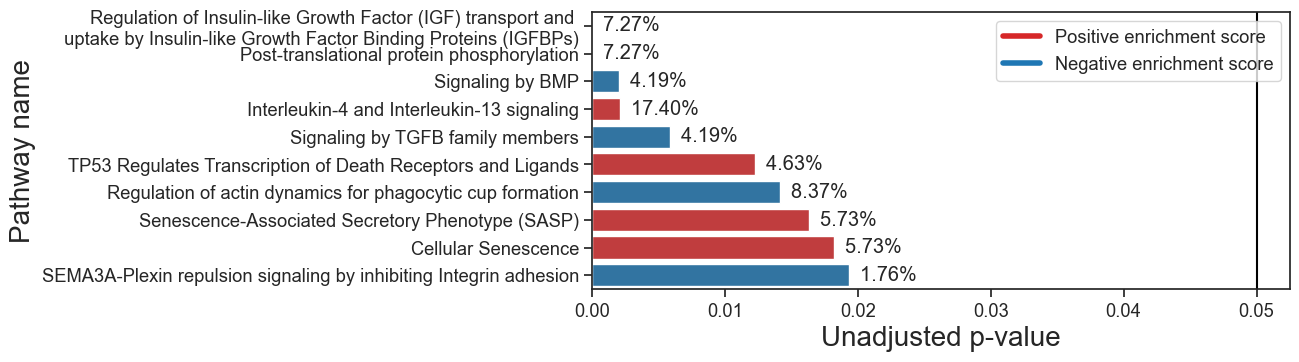

In [163]:
from matplotlib.lines import Line2D #To colour the bar by enrichment

top_10_pathways_gsea = gsea_res.sort_values(by="P-value").iloc[0:10, :]
plt.figure(figsize=(9, 3.6))

sns.set(font_scale = 1.2) #sns.set(font_scale = 1.2) for metabolomic because of long label
sns.set_style("ticks") # same as "white" but with ticks

# set bar colour based on normalised enrichment score sign
bar_color = ['tab:red' if float(i) > 0 else 'tab:blue' for i in top_10_pathways_gsea['NES']]
ax = sns.barplot(data=top_10_pathways_gsea, y="Pathway_name", x="P-value", orient="h", palette=bar_color)

label = []
for pathway in top_10_pathways_gsea["Entity %"]:
    label.append("  "+ pathway)

print(label)

ax.bar_label(ax.containers[0], labels=label)

#plt.title('GSEA for proteomic data',fontsize=22,pad=10)
plt.xlabel('Unadjusted p-value',fontsize=20)
plt.ylabel('Pathway name',fontsize=20) ;

plt.axvline(0.05, c="black")

# add legend
custom_lines = [Line2D([0], [0], color='tab:red', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
plt.legend(handles=custom_lines, labels=['Positive enrichment score', 'Negative enrichment score'],loc="upper right")

#plt.savefig( '../Figures/proteomic_GSEA_top_10.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

For integrated data, take the two GSEA results and combine the p-values with Fisher's method, which is what is commonly done (See Maghsoudi et al., 2021 for examples):

In [154]:
metabolomic_gsea = gsea_res.sort_values(by="P-value")
metabolomic_gsea = metabolomic_gsea.set_index(['Pathway_ID'])

In [165]:
proteomic_gsea = gsea_res.sort_values(by="P-value")
proteomic_gsea = proteomic_gsea.set_index(['Pathway_ID'])

In [155]:
metabolomic_gsea

,Pathway_name,ES,NES,P-value,P-adjust FDR,P-adjust FWER,Tag %,Entity %,Leading_edge
Pathway_ID,,,,,,,,,
R-HSA-189200,Cellular hexose transport,0.969877,1.545087,0.002024,0.752723,0.368,1/2,0.30%,4208
R-HSA-2408522,Selenoamino acid metabolism,0.96654,1.48528,0.006237,0.580781,0.55,1/2,3.30%,30831
R-HSA-2408508,"Metabolism of ingested SeMet, Sec, MeSec into ...",0.96654,1.48528,0.006237,0.580781,0.55,1/2,3.30%,30831
R-HSA-71291,Regulation of Insulin-like Growth Factor (IGF)...,0.579259,1.626558,0.025743,0.651087,0.2,10/16,26.43%,16946;30831;17509;16199;15999;17482;16530;1673...
R-HSA-71387,Metabolism of carbohydrates,0.775678,1.52676,0.03,0.589442,0.409,1/4,0.30%,4208
...,...,...,...,...,...,...,...,...,...
R-HSA-549127,Organic cation transport,0.315021,0.613019,0.920635,0.934859,1.0,3/4,40.54%,16737;15354;4828
R-HSA-381753,Olfactory Signaling Pathway,0.352902,0.58637,0.929607,0.941908,1.0,1/3,28.83%,422
R-HSA-112311,Neurotransmitter clearance,-0.330913,-0.582251,0.935743,0.97034,1.0,3/3,74.47%,27823;545959;15354


In [166]:
proteomic_gsea

,Pathway_name,ES,NES,P-value,P-adjust FDR,P-adjust FWER,Tag %,Entity %,Leading_edge
Pathway_ID,,,,,,,,,
R-HSA-381426,Regulation of Insulin-like Growth Factor (IGF)...,0.894649,1.840192,0.0,0.094269,0.08,5/8,7.27%,P05231;Q07065;P19022;P13611;P09603
R-HSA-8957275,Post-translational protein phosphorylation,0.92116,1.668227,0.0,0.320732,0.426,5/6,7.27%,P05231;Q07065;P19022;P13611;P09603
R-HSA-201451,Signaling by BMP,-0.964602,-1.490586,0.001984,1.0,0.911,2/2,4.19%,Q15797;Q9UK05
R-HSA-6785807,Interleukin-4 and Interleukin-13 signaling,0.681918,1.82879,0.002053,0.056074,0.095,12/22,17.40%,P05231;P01375;P14210;P10145;P13500;P24394;P137...
R-HSA-9006936,Signaling by TGFB family members,-0.723535,-1.686862,0.005848,1.0,0.402,2/7,4.19%,Q15797;Q9UK05
...,...,...,...,...,...,...,...,...,...
R-HSA-8940973,RUNX2 regulates osteoblast differentiation,-0.307673,-0.488683,0.989754,0.998936,1.0,1/2,27.31%,P07947
R-HSA-71291,Metabolism of amino acids and derivatives,0.179672,0.417433,0.994275,0.998964,1.0,5/9,43.61%,P23526;P50135;Q9UJM8;P05089;P25786
R-HSA-9034015,Signaling by NTRK3 (TRKC),-0.310756,-0.465698,0.997899,0.997423,1.0,1/2,27.09%,P20783


In [167]:
result = metabolomic_gsea.merge(proteomic_gsea, how='inner',right_index=True, left_index = True)
result[:5]

,Pathway_name_x,ES_x,NES_x,P-value_x,P-adjust FDR_x,P-adjust FWER_x,Tag %_x,Entity %_x,Leading_edge_x,Pathway_name_y,ES_y,NES_y,P-value_y,P-adjust FDR_y,P-adjust FWER_y,Tag %_y,Entity %_y,Leading_edge_y
Pathway_ID,,,,,,,,,,,,,,,,,,
R-HSA-2408522,Selenoamino acid metabolism,0.96654,1.48528,0.006237,0.580781,0.55,1/2,3.30%,30831,Selenoamino acid metabolism,0.794248,1.182138,0.266932,0.773021,1.0,2/2,20.93%,P23526;P50135
R-HSA-2408508,"Metabolism of ingested SeMet, Sec, MeSec into ...",0.96654,1.48528,0.006237,0.580781,0.55,1/2,3.30%,30831,"Metabolism of ingested SeMet, Sec, MeSec into ...",0.794248,1.182138,0.266932,0.773021,1.0,2/2,20.93%,P23526;P50135
R-HSA-71291,Regulation of Insulin-like Growth Factor (IGF)...,0.579259,1.626558,0.025743,0.651087,0.2,10/16,26.43%,16946;30831;17509;16199;15999;17482;16530;1673...,Metabolism of amino acids and derivatives,0.179672,0.417433,0.994275,0.998964,1.0,5/9,43.61%,P23526;P50135;Q9UJM8;P05089;P25786
R-HSA-71387,Metabolism of carbohydrates,0.775678,1.52676,0.03,0.589442,0.409,1/4,0.30%,4208,Metabolism of carbohydrates,0.38097,0.981285,0.497076,0.86524,1.0,6/10,33.92%,P13611;Q11201;P09467;P07585;P00352;P51888
R-HSA-597592,Post-translational protein modification,0.801903,1.42451,0.043651,0.585367,0.743,3/4,9.01%,4208;16680;17509,Post-translational protein modification,0.305563,0.982479,0.479371,0.868653,1.0,18/38,43.61%,P15514;P05231;Q07065;P19022;P13611;P09603;P011...


In [168]:
result["combined_pval"] = 0

In [169]:
for i in range(len(result.index)):
    ID_list = [result["P-value_x"][i],result["P-value_y"][i]]
    print(ID_list)
    test_stat,pval = scipy.stats.combine_pvalues(ID_list, method='fisher',weights=None)
    print(pval)
    result["combined_pval"][i] = pval


[0.006237006237006237, 0.26693227091633465]
0.012316646723185201
[0.006237006237006237, 0.26693227091633465]
0.012316646723185201
[0.02574257425742574, 0.9942748091603053]
0.1194105524469273
[0.03, 0.49707602339181284]
0.07762692399530659
[0.04365079365079365, 0.4793713163064833]
0.10183777495887114
[0.0437375745526839, 0.3987730061349693]
0.08805988884049253
[0.09073359073359073, 0.4841897233201581]
0.1812252839796926
[0.1976284584980237, 0.6900584795321637]
0.40808168528499134
[0.20758483033932135, 0.5356415478615071]
0.35542281180558577
[0.22549019607843138, 0.39549180327868855]
0.30473569253641736
[0.2459016393442623, 0.6906614785992218]
0.4709398375150151
[0.2633663366336634, 0.7212121212121212]
0.5054442495976447
[0.2984189723320158, 0.3844621513944223]
0.363142115260965
[0.300990099009901, 0.2796116504854369]
0.292459827666266
[0.3303964757709251, 0.2964509394572025]
0.32550856203717404
[0.3521739130434783, 0.30505050505050507]
0.347099136816296
[0.37103174603174605, 0.400398406

C:\Users\jenna\AppData\Local\Temp\ipykernel_20852\54959011.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["combined_pval"][i] = pval


12.115
12.115
21.34
17.11
21.34
18.89
26.31
21.34
35.019999999999996
5.0249999999999995
['  12.1%', '  12.1%', '  21.3%', '  17.1%', '  21.3%', '  18.9%', '  26.3%', '  21.3%', '  35.0%', '  5.0%']


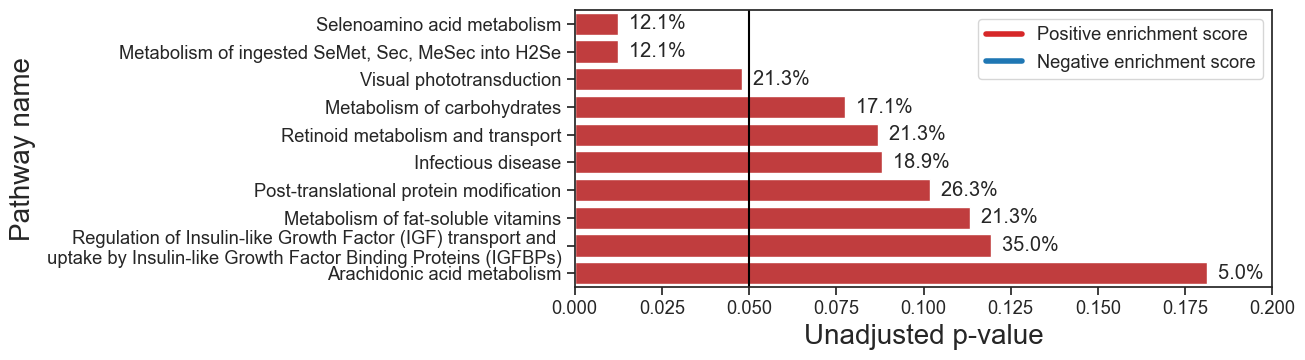

In [175]:
from matplotlib.lines import Line2D

top_10_pathways_gsea = result.sort_values(by="combined_pval").iloc[0:10, :]
plt.figure(figsize=(9, 3.6))

sns.set(font_scale = 1.2) #sns.set(font_scale = 1.2)  because of long label
sns.set_style("ticks") # same as "white" but with ticks

# set bar colour based on normalised enrichment score sign
bar_color = ['tab:red' if float(i) > 0 else 'tab:blue' for i in top_10_pathways_gsea['NES_x']]
ax = sns.barplot(data=top_10_pathways_gsea, y="Pathway_name_x", x="combined_pval", orient="h", palette=bar_color)

label=[]
for i in range(10):
    pathway1 =  top_10_pathways_gsea["Entity %_x"][i][:-1]
    
    pathway2 =  top_10_pathways_gsea["Entity %_y"][i][:-1]

    percent = (float(pathway1)+float(pathway2))/2
    print(percent)
    label.append("  "+ str(round(percent,1))+ '%')

print(label)


ax.bar_label(ax.containers[0], labels=label)

#plt.title('GSEA for integrated data',fontsize=22, pad=10)
plt.xlabel('Unadjusted p-value',fontsize=20)
plt.ylabel('Pathway name',fontsize=20) 
plt.xlim(0, 0.2);

plt.axvline(0.05, c="black")

#Add legend
custom_lines = [Line2D([0], [0], color='tab:red', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
plt.legend(handles=custom_lines, labels=['Positive enrichment score', 'Negative enrichment score'],loc="upper right")


#plt.savefig( '../Figures/integrated_GSEA_top_10.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')